In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load simulation data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'neuronal_model_491766131_Loc5_restrict_h')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
labels = STATS['y']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list and STATS['ys'].size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = STATS['ys']
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,vx,vy,vz
2573,-118.526630,195.325175,0.132621,0.051230,0.998585,0.014293
3532,-115.602066,194.980749,0.607523,0.122425,0.991246,-0.049432
5552,-112.028828,197.941575,-0.449781,-0.192798,0.981102,-0.016355
687,-111.158663,193.884559,-0.397310,0.377020,0.916617,0.132924
5564,-109.931469,190.583289,0.019839,-0.188784,0.981098,0.042511
...,...,...,...,...,...,...
4627,170.253966,179.686860,0.536565,0.232388,0.963395,-0.133661
4655,171.035447,198.938301,0.227363,0.084516,0.993706,-0.073521
3227,172.122425,184.732789,-0.308625,-0.303313,0.948545,-0.090902
1081,173.776359,195.594970,0.440230,-0.155093,0.987828,0.011899


### Normalizing labels

#### Set bounds for y shift

In [5]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))
#     labels = labels[df_la_idx,:]
#     summ_stats = summ_stats[df_la_idx,:]
#     with pd.option_context('display.max_rows',10):
#         display(df_la.loc[df_la_idx])

print(json.dumps(ranges))

1.63% outside bounds.
{"x": [-50, 50], "y": [-1200, 1200], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.9, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "r_s": [5.0, 12.0], "l_t": [20.0, 800.0], "r_t": [0.2, 0.8], "r_d": [0.1, 0.5], "r_tu": [0.05, 0.4], "l_d": [100.0, 300.0], "r_a": [0.1, 0.5], "r_o": [0.1, 0.5], "l_o": [10.0, 150], "vx": [-1.0, 1.0], "vy": [-1.0, 1.0], "vz": [-1.0, 1.0], "ys": [-150, 150]}


#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,vx,vy,vz
0,-0.027407,-0.545328,0.037867,-0.083005,0.952476,0.293088
1,-0.207822,-0.366483,0.533298,0.405870,0.911512,-0.066457
2,-0.197236,0.594731,-0.118573,-0.138803,0.967601,0.210907
3,-0.224107,0.352509,-0.009053,-0.110639,0.904410,0.412071
4,0.729526,-0.217781,-0.441136,0.087218,0.938711,-0.333489
...,...,...,...,...,...,...
5995,-0.134074,-0.160493,-0.834186,-0.198456,0.978986,0.046918
5996,-0.265075,-0.212319,0.047885,-0.184935,0.959982,-0.210316
5997,-0.182577,-0.082288,0.185007,0.357636,0.933330,-0.031474
5998,0.853546,0.841172,-0.103618,-0.085078,0.945431,-0.314520


## Build model

In [7]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

isTrain = False
model_name = 'FCN_batch256'
if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name + '.pth')
SAVE_PATH = os.path.join(TRIAL_PATH, model_name + '.txt')

model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=len(label_list))

## Train model

In [8]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=256, shuffle=True)
if isTrain:
    history, files = train_regression(model, train_loader, test_loader, epochs=100, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), MODEL_PATH)
    with open(SAVE_PATH, 'w') as f:
        f.writelines(s + '\n' for s in files)

  1%|▍                                         | 1/100 [00:00<01:06,  1.49it/s]

Training Loss: 4.104235306382179 Validation Loss: 1.1768678426742554


 11%|████▌                                    | 11/100 [00:06<01:06,  1.34it/s]

Training Loss: 0.583527771756053 Validation Loss: 0.1857764683663845


 21%|████████▌                                | 21/100 [00:12<00:51,  1.53it/s]

Training Loss: 0.36000384390354156 Validation Loss: 0.12068301625549793


 31%|████████████▋                            | 31/100 [00:17<00:38,  1.79it/s]

Training Loss: 0.3263025935739279 Validation Loss: 0.11107510887086391


 41%|████████████████▊                        | 41/100 [00:21<00:25,  2.33it/s]

Training Loss: 0.31042662635445595 Validation Loss: 0.10455143265426159


 51%|████████████████████▉                    | 51/100 [00:24<00:17,  2.74it/s]

Training Loss: 0.30309310276061296 Validation Loss: 0.10297798365354538


 61%|█████████████████████████                | 61/100 [00:31<00:28,  1.37it/s]

Training Loss: 0.2995104677975178 Validation Loss: 0.10270494595170021


 71%|█████████████████████████████            | 71/100 [00:36<00:18,  1.58it/s]

Training Loss: 0.2951208120211959 Validation Loss: 0.0997233148664236


 81%|█████████████████████████████████▏       | 81/100 [00:42<00:11,  1.69it/s]

Training Loss: 0.29231471195816994 Validation Loss: 0.09841339569538832


 91%|█████████████████████████████████████▎   | 91/100 [00:47<00:05,  1.52it/s]

Training Loss: 0.2893469501286745 Validation Loss: 0.09813904669135809


100%|████████████████████████████████████████| 100/100 [00:52<00:00,  1.92it/s]


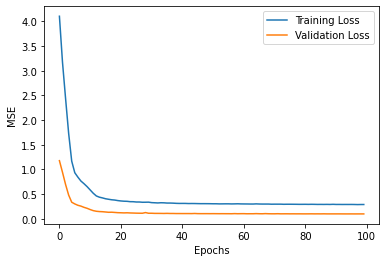

In [9]:
if not isTrain:
    with open(SAVE_PATH, 'r') as f:
        loss_file = f.read().splitlines()[1]
    history = pd.read_csv(loss_file).to_dict(orient='list')
plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Evaluate model

In [10]:
if not isTrain:
    model.load_state_dict(torch.load(MODEL_PATH))

### Perform on stylized model

In [11]:
from sklearn.metrics import r2_score
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# back to original scale
for i, lb in enumerate(label_list):
    y[:,i] = org_scale(y[:,i], ranges[lb])
    output[:,i] = org_scale(output[:,i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
for i, p in enumerate(display_list):
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(y[:,i], output[:,i])))

R2 Score y-shift:   0.970
R2 Score d:         0.970
R2 Score theta:     0.810
R2 Score vx:        0.079
R2 Score vy / h:    -1.069
R2 Score vz:        0.721
R2 Score phi:       -0.990


Stylized Cell Testing Data: Ground Truth VS Predicted


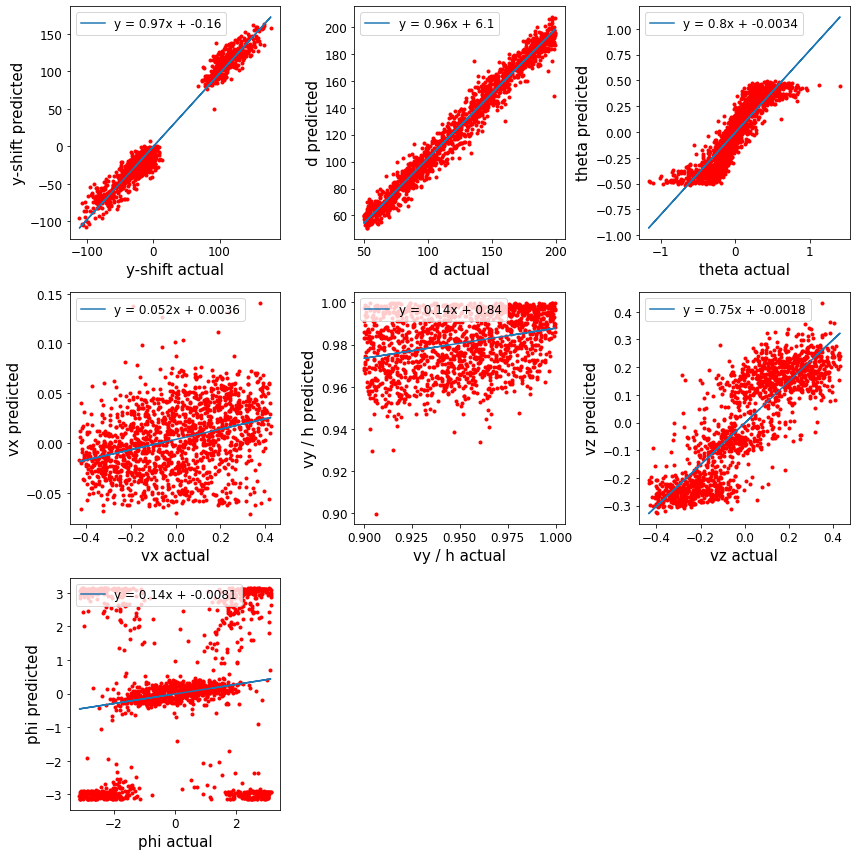

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:,i], output[:,i], c='red', marker='.')
    m, b = np.polyfit(y[:,i], output[:,i], 1)
    ax.plot(y[:,i], m * y[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

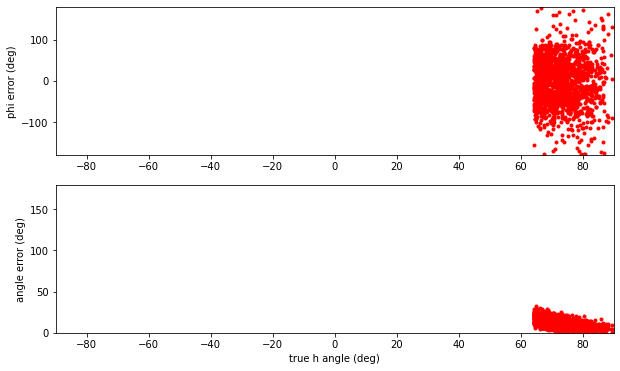

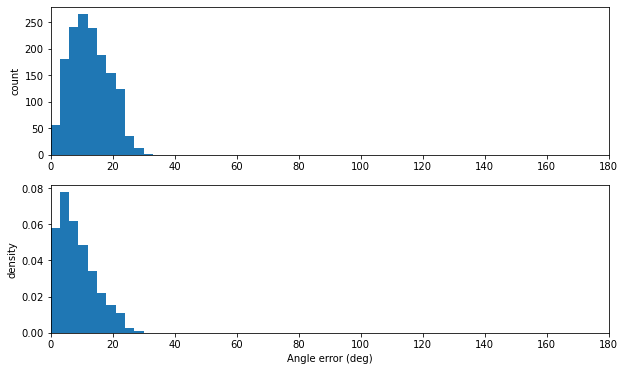

RMSE of angle: 14.0


In [13]:
if check_orient:
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

    bins = 60
    angle = np.arccos(cosine_similarity(y[:, orient_idx2], output[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (output[:, orient_idx2[1]] - y[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

### Perform on detailed model (Random cases)

In [14]:
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed.npz')  # summary statistics
# STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed_strch.npz')  # summary statistics

#### Ground truth

In [15]:
STATS = np.load(STATS_PATH)
summ_stats_test = STATS['x']
labels_true = STATS['y']
if direction_vec:
    dv = hphi2unitsphere(labels_true[:, orient_idx0])
    labels_true = np.hstack([np.delete(labels_true, orient_idx0, axis=1), dv, labels_true[:, [orient_idx0[1]]]])
if has_yshift:
    labels_true[:, ys_idx] = STATS['ys']

#### Prediction

In [16]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(label_list):
    labels_pred[:,i] = org_scale(labels_pred[:,i], ranges[lb])

# transform orientation variables
if direction_vec:
    labels_pred[:, orient_idx1] = trivarnorm2unitsphere(labels_pred[:, orient_idx1])
    labels_pred = np.hstack([labels_pred, unitsphere2hphi(labels_pred[:, orient_idx1])[:, [1]]])

for i, p in enumerate(display_list):
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(labels_true[:,i], labels_pred[:,i])))

R2 Score y-shift:   0.268
R2 Score d:         0.646
R2 Score theta:     0.798
R2 Score vx:        -0.013
R2 Score vy / h:    -1.624
R2 Score vz:        -0.573
R2 Score phi:       -1.139


Detailed Cell Testing Data: Ground Truth VS Predicted


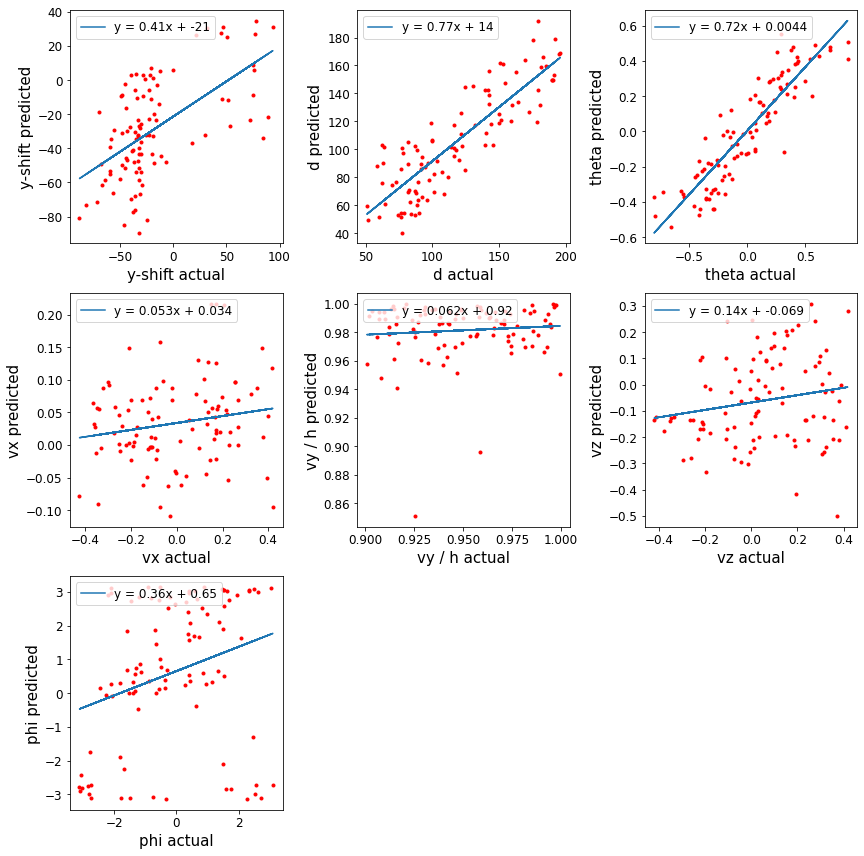

In [17]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Detailed Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(labels_true[:,i], labels_pred[:,i], c='red', marker='.')
    m, b = np.polyfit(labels_true[:,i], labels_pred[:,i], 1)
    ax.plot(labels_true[:,i], m * labels_true[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

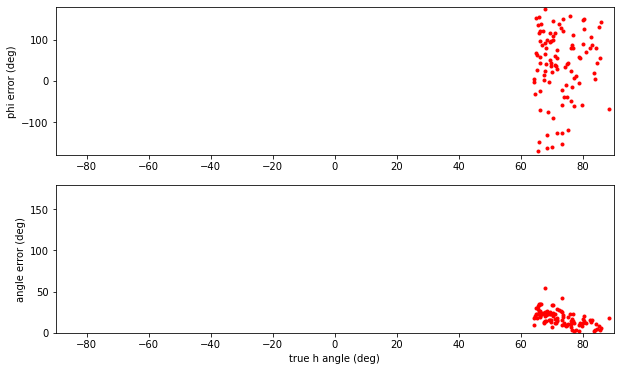

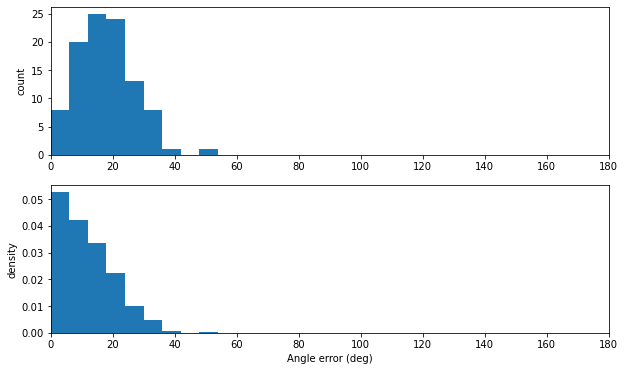

RMSE of angle: 20.4


In [18]:
if check_orient:
    bins = 30
    angle = np.arccos(cosine_similarity(labels_true[:, orient_idx2], labels_pred[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (labels_pred[:, orient_idx2[1]] - labels_true[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(labels_true[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)